# THE PROBLEM STATEMENT.

A Kenyan entrepreneur has created an online cryptography course and would want to advertise it on her blog. She currently targets audiences originating from various countries. In the past, she ran ads to advertise a related course on the same blog and collected data in the process. She would now like to employ your services as a Data Science Consultant to create a solution that would allow her to determine whether ads targeted to audiences of certain characteristics i.e. city, male country, advertisement topic, etc. would click on her ads. Ceate a prediction model that more accurately predicts whether a user will click an Advert

# PROJECT OBJECTIVE.

In [ ]:

Create a prediction model that more accurately predicts whether a user will Click an Advertisement.

In [ ]:
METRICS OF SUCCESS.
1.Confusion Matrix
2.RMSE
3.Accuracy

In [2]:
# Importing the relevant libaries

library(remotes)
library(pacman)
library(gmodels)
library(outliers)
library(tidyverse)
library(xgboost)
library(corrplot)
library(ggplot2)
library(caret)
library(class)
library(tidyverse)
library(lubridate)
library(ggcorrplot)
theme_set(theme_classic())
options(warn = -1)

Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 3.2.1       v purrr   0.3.2  
v tibble  2.1.1       v dplyr   0.8.0.1
v tidyr   0.8.3       v stringr 1.4.0  
v readr   1.3.1       v forcats 0.4.0  
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Attaching package: 'xgboost'

The following object is masked from 'package:dplyr':

    slice

corrplot 0.84 loaded
Loading required package: lattice

Attaching package: 'caret'

The following object is masked from 'package:purrr':

    lift


Attaching package: 'lubridate'

The following object is masked from 'package:base':

    date



In [171]:
# Loading the dataset and displaying the first 6 rows

advert <- read.csv("http://bit.ly/IPAdvertisingData")
head(advert)

Daily.Time.Spent.on.Site,Age,Area.Income,Daily.Internet.Usage,Ad.Topic.Line,City,Male,Country,Timestamp,Clicked.on.Ad
<dbl>,<int>,<dbl>,<dbl>,<fct>,<fct>,<int>,<fct>,<fct>,<int>
68.95,35,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,2016-03-27 00:53:11,0
80.23,31,68441.85,193.77,Monitored national standardization,West Jodi,1,Nauru,2016-04-04 01:39:02,0
69.47,26,59785.94,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,2016-03-13 20:35:42,0
74.15,29,54806.18,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,2016-01-10 02:31:19,0
68.37,35,73889.99,225.58,Robust logistical utilization,South Manuel,0,Iceland,2016-06-03 03:36:18,0
59.99,23,59761.56,226.74,Sharable client-driven software,Jamieberg,1,Norway,2016-05-19 14:30:17,0


In [173]:
#Checking the dimensions of the dataset
dim(advert)

[1] 1000   10

The dataset has 1000 rows and 10 columns

In [158]:
# The male column should be renamed to gender
colnames(advert)[colnames(advert) == 'Male'] = 'Gender'

In [159]:
#Checking the column names
attributes(advert)$names


[1] "Daily.Time.Spent.on.Site" "Age"                     
 [3] "Area.Income"              "Daily.Internet.Usage"    
 [5] "Ad.Topic.Line"            "City"                    
 [7] "Gender"                   "Country"                 
 [9] "Timestamp"                "Clicked.on.Ad"

In [125]:
table(advert$Clicked_on_Ad)

< table of extent 0 >

In [133]:
# Checking the datatypes for each column
columns = colnames(advert)
for (column in seq(length(colnames(advert)))){
    print(columns[column])
    print(class(advert[, column]))
    cat('\n')
}

[1] "Daily.Time.Spent.on.Site"
[1] "numeric"

[1] "Age"
[1] "integer"

[1] "Area.Income"
[1] "numeric"

[1] "Daily.Internet.Usage"
[1] "numeric"

[1] "Ad.Topic.Line"
[1] "factor"

[1] "City"
[1] "factor"

[1] "Gender"
[1] "integer"

[1] "Country"
[1] "factor"

[1] "Timestamp"
[1] "factor"

[1] "Clicked.on.Ad"
[1] "integer"



In [127]:
# Changing column names to their appriopriate data type
# Creating a lists of categorical and numerical columns 

# List of categorical columns
cat.cols = c("Ad.Topic.Line", "City", "Gender", "Country", "Clicked.on.Ad" )

# List of numerical columns
num.cols = c("Daily.Time.Spent.on.Site", "Age", "Area.Income", "Daily.Internet.Usage")

# Changing columns to factors
advert[,cat_cols] %<>% lapply(function(x) as.factor(as.character(x)))

In [58]:
# Summary of numeric columns

advert %>%
  select_if(is.numeric) %>%
  map(~summary(.))

$Daily.Time.Spent.on.Site
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  32.60   51.36   68.22   65.00   78.55   91.43 

$Age
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  19.00   29.00   35.00   36.01   42.00   61.00 

$Area.Income
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  13996   47032   57012   55000   65471   79485 

$Daily.Internet.Usage
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  104.8   138.8   183.1   180.0   218.8   270.0 

$Gender
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   0.000   0.000   0.481   1.000   1.000 

$Clicked.on.Ad
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.0     0.0     0.5     0.5     1.0     1.0 


# Checking the number of unique attributes

cat.columns <- c("Ad.Topic.Line","City","Country","Timestamp")
no <- function(x) {  
    nlevels(x)
  }
  
number <- sapply(select(advert, cat.columns), no)
number

# DATA CLEAN UP


In [59]:
# Checking for Missing values

colSums(is.na(advert))

Daily.Time.Spent.on.Site                      Age              Area.Income 
                       0                        0                        0 
    Daily.Internet.Usage            Ad.Topic.Line                     City 
                       0                        0                        0 
                  Gender                  Country                Timestamp 
                       0                        0                        0 
           Clicked.on.Ad 
                       0

There is no missing values in our dataset

In [60]:
# Checking for duplicatated values

anyDuplicated(advert)

[1] 0

There are no duplicate values.

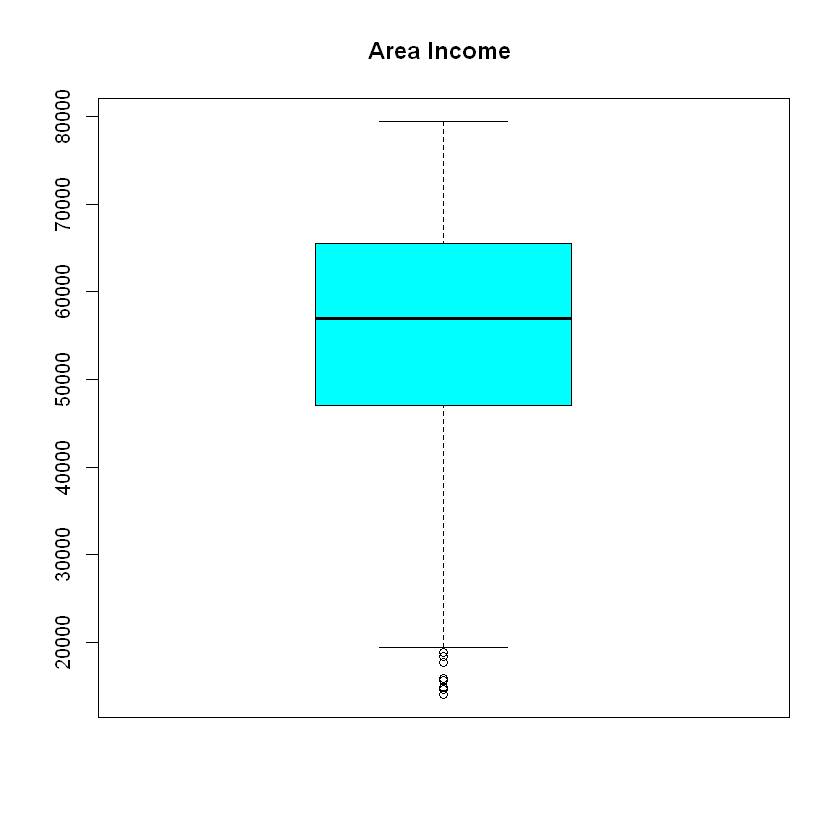

In [61]:
# Checking outliers using boxplots on area income
boxplot(advert$Area.Income,main = "Area Income ",col=5)


There are duplicates at the incomes below 2000

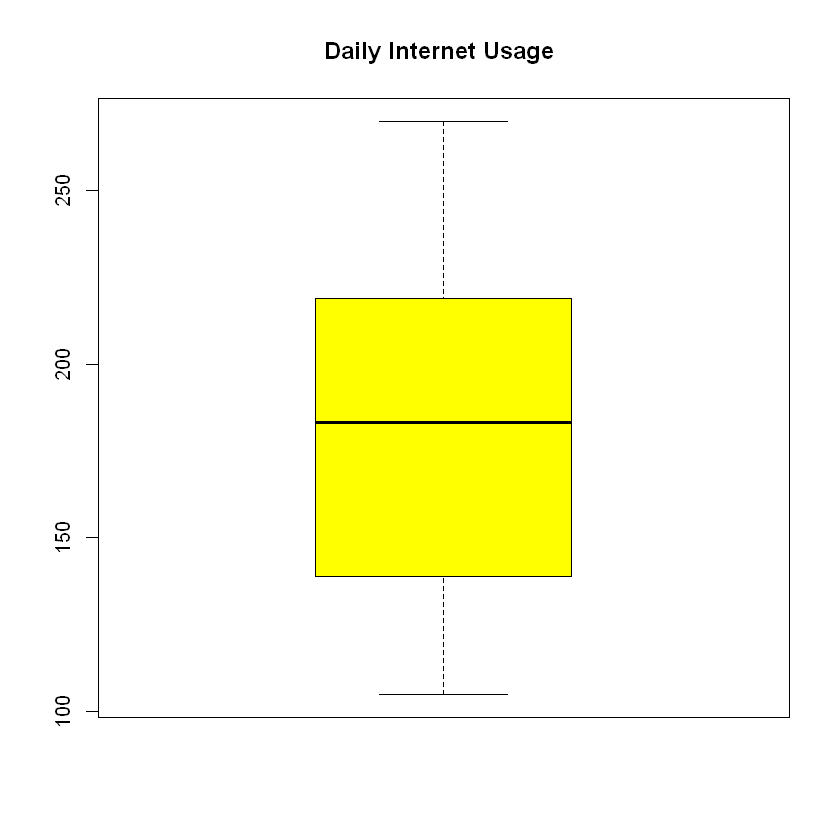

In [62]:
# Plotting boxplots on  Daily Internet Usage
boxplot(advert$Daily.Internet.Usage,main = "Daily Internet Usage ",col=7)

There are no outliers on the daily internet usage.

# EXPLORATIVE DATA ANALYSIS.

Univariate Analysis

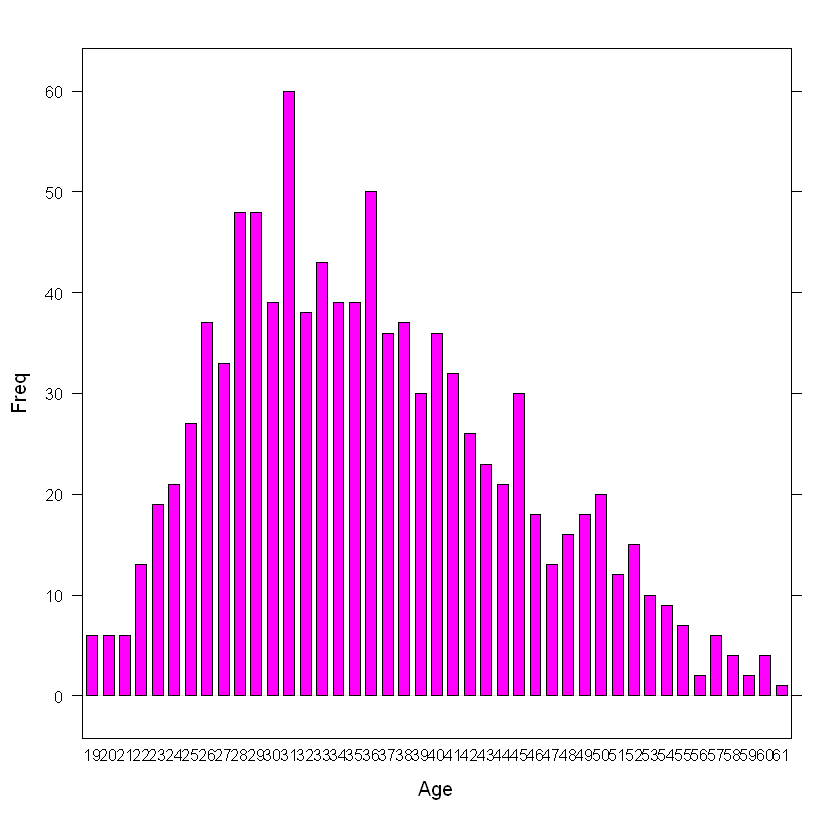

In [63]:
barchart(table(advert$'Age'
),horizontal=FALSE,
xlab="Age
",col="magenta")

Age is normally distributed.

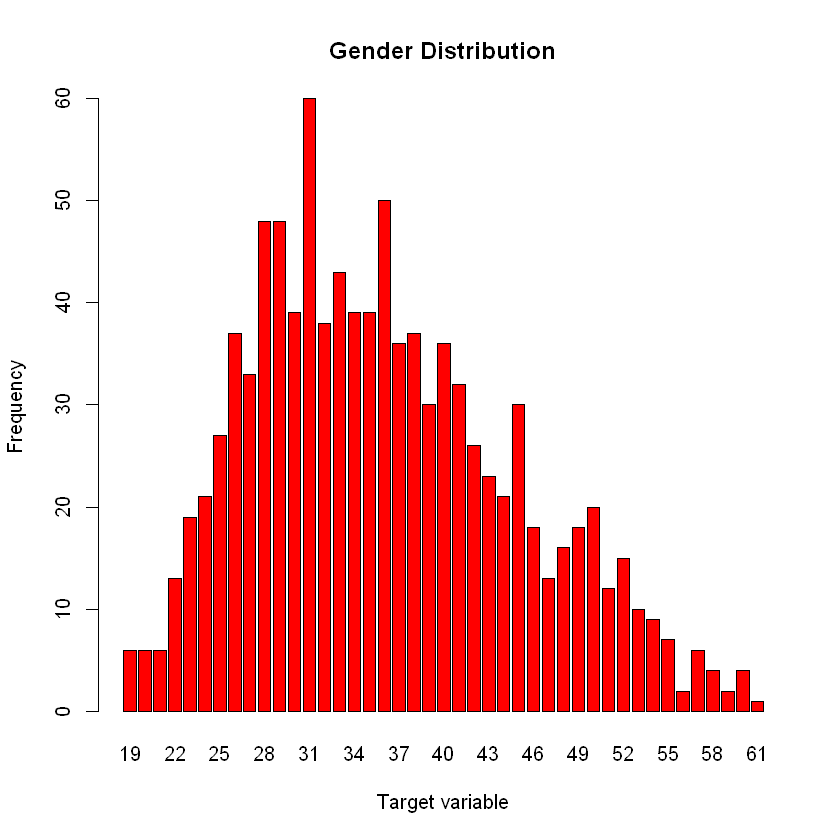

In [66]:
# Plotting barplots of the Gender column

counts <- table(advert$Age)
barplot(counts, main="Gender Distribution",xlab="Target variable",ylab = "Frequency",col=2)


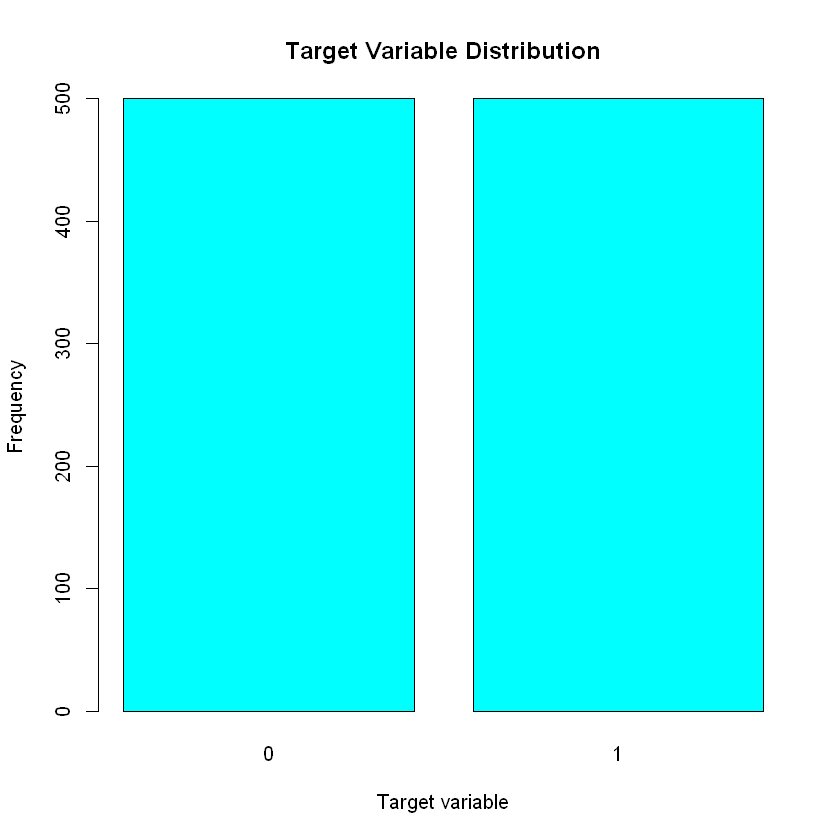

In [67]:
# Plotting barplots of the target column

counts <- table(advert$Clicked.on.Ad)
barplot(counts, main="Target Variable Distribution",xlab="Target variable",ylab = "Frequency",col="cyan")

# Bivariate Analysis.

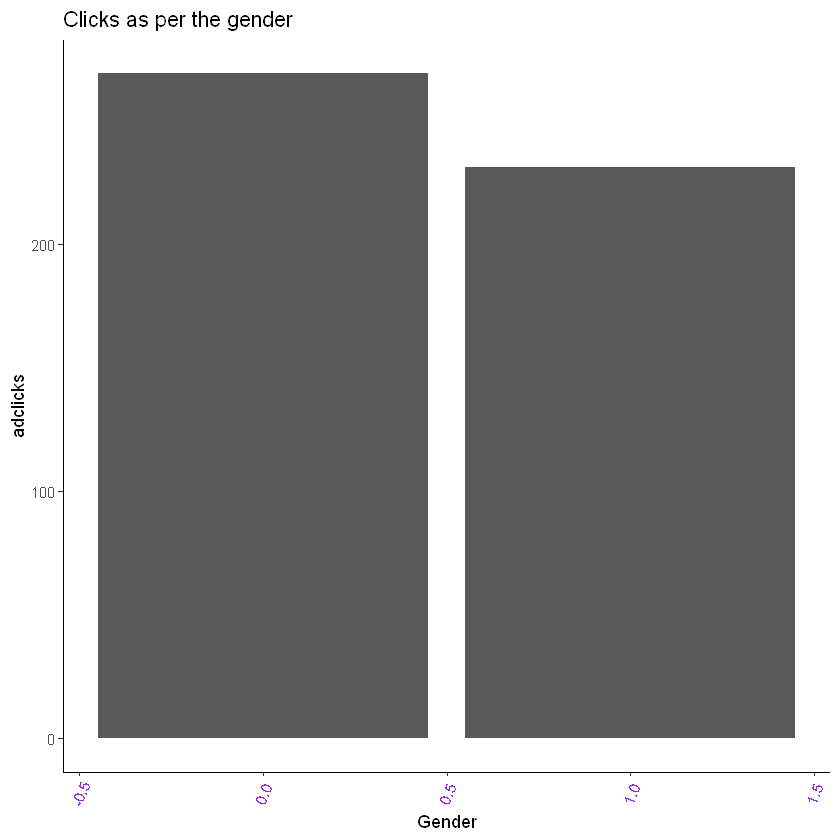

In [69]:
#Checking the adclick as per the gender
ggplot(advert, aes(Gender,Clicked.on.Ad )) + geom_bar( stat = "identity") + theme(axis.text.x = element_text(angle = 70, vjust = 0.5, color='purple')) + xlab("Gender") + ylab("adclicks")+ggtitle("Clicks as per the gender")
#Males reported to have more clicks as compared to female

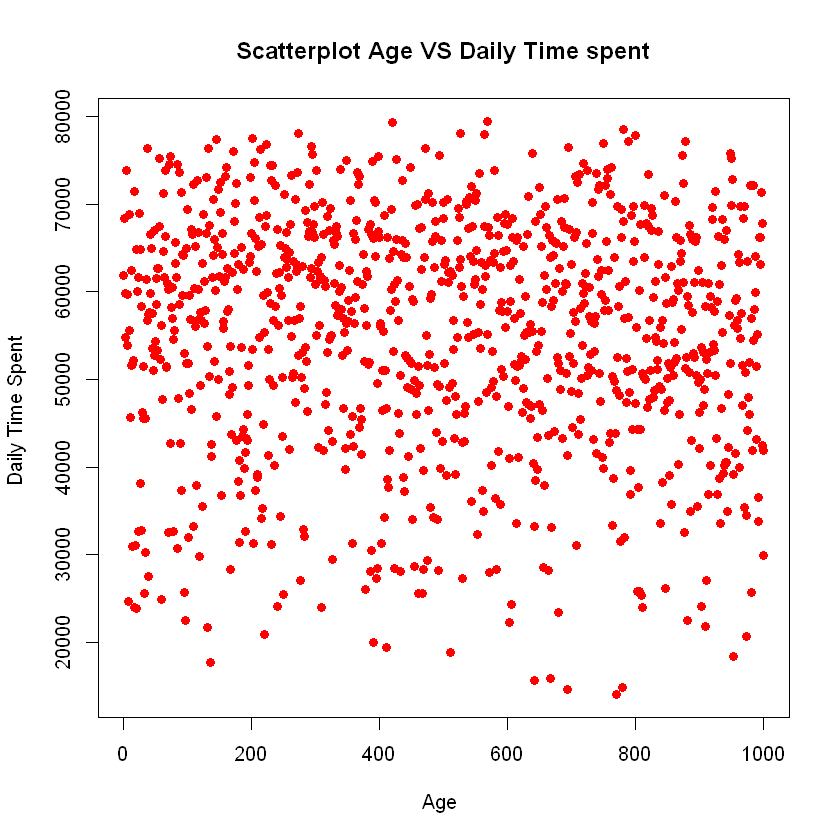

In [17]:
# Plotting a scatter plot between variables

plot(advert$Area.Income, advert$age, main="Scatterplot Age VS Daily Time spent",
   xlab="Age ", ylab="Daily Time Spent ", pch=19, col=2)

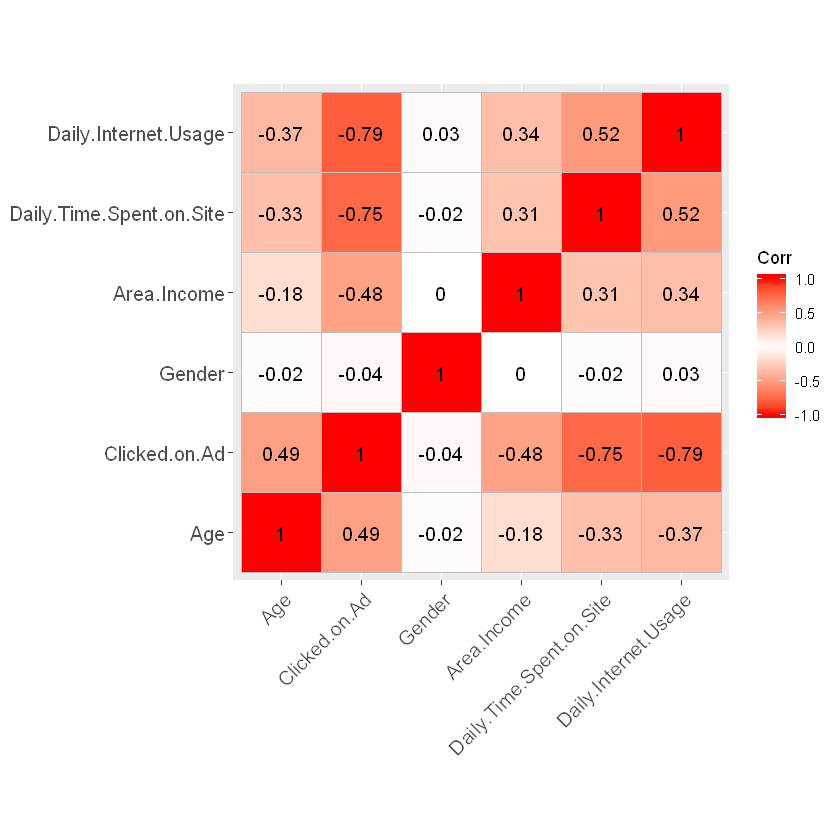

In [78]:
corr = round(cor(select_if(advert, is.numeric)), 2)
ggcorrplot(corr, hc.order = T, ggtheme = ggplot2::theme_gray,
   colors = c("red", "white", "red"), lab = T)

There is a high correlation betweem Age and the number of ads clicked of 0.49

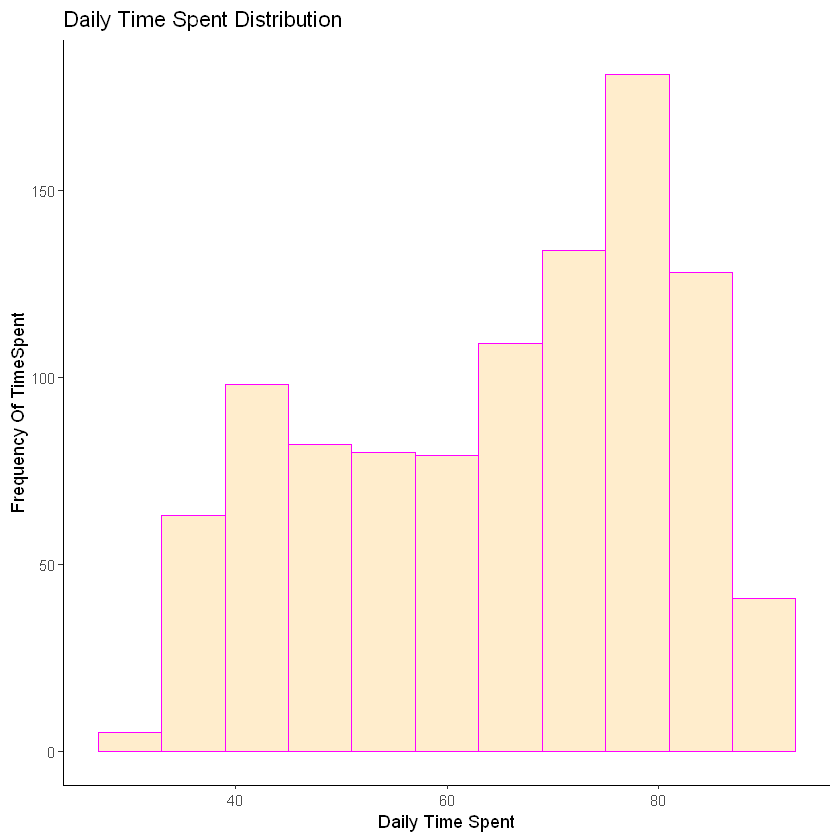

In [82]:
# Plotting a histogram of daily Time Spent

qplot(advert$Daily.Time.Spent.on.Site,main = "Daily Time Spent Distribution",geom="histogram",
    xlab = "Daily Time Spent",ylab = "Frequency Of TimeSpent",binwidth = 6,fill=I("orange"),col=I("magenta"), alpha=I(.2),)

Daily time spent online is about 80minutes. 

## MODELLING

In [136]:
# Selecting the columns that will be used for modelling

advert.df <- select(advert,c("Daily.Time.Spent.on.Site" ,"Age" ,"Area.Income","Gender","Clicked.on.Ad"))
head(advert.df)

Daily.Time.Spent.on.Site,Age,Area.Income,Gender,Clicked.on.Ad
<dbl>,<int>,<dbl>,<int>,<int>
68.95,35,61833.90,0,0
80.23,31,68441.85,1,0
69.47,26,59785.94,0,0
74.15,29,54806.18,1,0
68.37,35,73889.99,0,0
59.99,23,59761.56,1,0


In [139]:
# Training the model
model = train(Clicked.on.Ad ~ ., data = train, method = 'earth')

# Making predictions using the training set
pred = predict(model)

In [167]:
# Splitting the data into training and testing sets
# Setting the seed to 100, for reproducibility
set.seed(150)

# Selecting only columns that are relevant to modeling
 impor.cols= c('Daily.Time.Spent.on.Site', 'Age', 'Area.Income', 'Daily.Internet.Usage', 'Gender', 'Clicked.on.Ad')
advert.df = select(advert, impor.cols)

# Splitting the data into 80% training and 20% testing
train.rows = createDataPartition(advert.df$Clicked.on.Ad, p=0.8, list=FALSE)

# Creating the training  dataset
train = advert.df[train.rows,]

# Creating the test dataset
test = advert.df[-train.rows,]

# Creating the  X and Y variables
x = train
y = train$Clicked.on.Ad


In [141]:
#Checking the model performance.
model

Multivariate Adaptive Regression Spline 

700 samples
  5 predictor

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 700, 700, 700, 700, 700, 700, ... 
Resampling results across tuning parameters:

  nprune  RMSE       Rsquared   MAE      
   2      0.2990051  0.6432675  0.2124800
   7      0.2213048  0.8044390  0.1495103
  13      0.2224785  0.8028511  0.1479868

Tuning parameter 'degree' was held constant at a value of 1
RMSE was used to select the optimal model using the smallest value.
The final values used for the model were nprune = 7 and degree = 1.

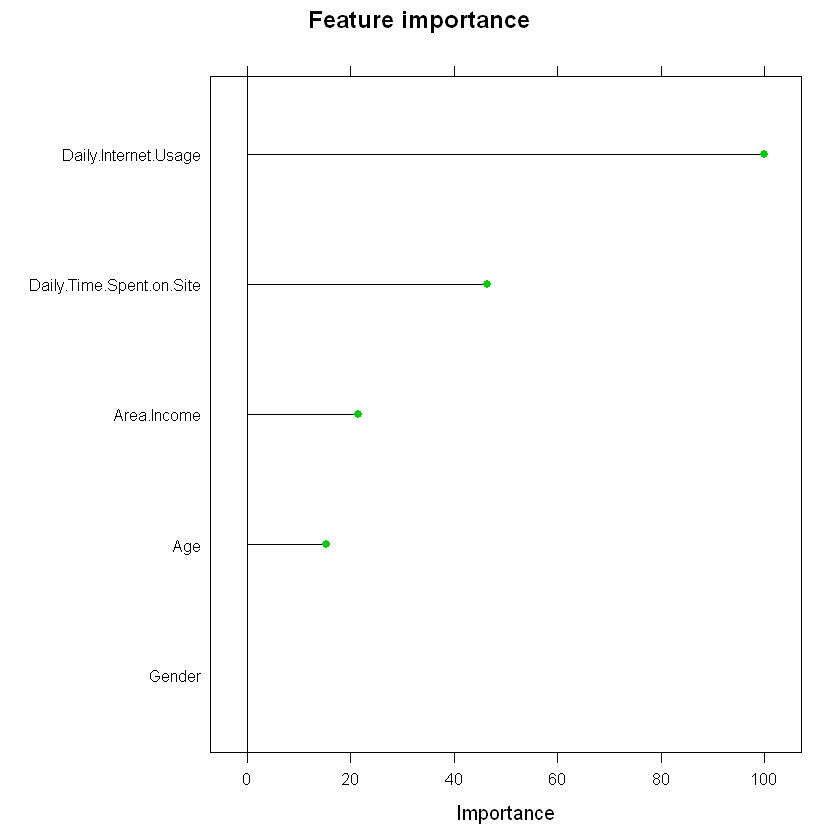

In [168]:
# Checking which features were important in predicting the target variable
important.features = varImp(model)

# Plotting feature importance
plot(important.features, main = 'Feature importance', col=3)


In [ ]:
 Daily internet usage is the most important feature.

 Challenging my Model

In [164]:

y.pred <- knn(train = x, test = x,
                      cl = y, k = 21)
 

In [170]:
# The accuracy

print(mean(y == y.pred ))

[1] 0.52375


# Conclusion.


The accuracy was 52% this means that more data collection is needed and application of better models to improve how the modelcan learn.